
#  Projet : Détection d'Anomalies sur Capteurs Industriels (Kaggle)

**Objectif :** Identifier des comportements thermiques anormaux pour anticiper les pannes sur une pompe industrielle.
**Algorithme :** `IsolationForest` (Apprentissage non-supervisé)



## 1. Introduction et Base Théorique

L'objectif de ce notebook est d'analyser les séries temporelles issues de capteurs industriels pour isoler les anomalies avant ou pendant une défaillance. Nous nous concentrons sur les capteurs représentant des variables thermiques.

L'**Isolation Forest** détecte les anomalies en isolant les observations. Le score d'anomalie est calculé selon la profondeur du chemin dans l'arbre. Formellement, le score d'anomalie  pour une observation  avec un échantillon de taille  est défini par où  est l'espérance de la longueur du chemin et  est la longueur moyenne non réussie d'une recherche dans un arbre binaire de recherche. Les anomalies ont des longueurs de chemin plus courtes, ce qui donne un score proche de 1.


## 2. Configuration de l'Environnement

In [1]:
# Importation des bibliothèques nécessaires à l'analyse de données et au Machine Learning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn pour le modèle, la préparation des données et les métriques d'évaluation
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Paramétrage visuel pour des graphiques professionnels
plt.style.use('seaborn-v0_8-darkgrid')
import warnings
warnings.filterwarnings('ignore') # Masque les avertissements non critiques


## 3. Chargement et Nettoyage des Données (sensor.csv)

Le dataset Kaggle contient des valeurs manquantes et des colonnes inutiles qu'il faut nettoyer avant d'entraîner notre modèle.

In [2]:
# 1. Chargement du dataset (Assurez-vous que sensor.csv est dans le dossier Colab)
# L'index 0 correspond à la colonne d'indexation d'origine du CSV
df = pd.read_csv('sensor.csv', index_col=0)

# Convertir la colonne timestamp au format datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# 2. Nettoyage des données industrielles
# Le capteur 15 (sensor_15) est connu dans ce dataset pour être complètement vide (NaN)
if 'sensor_15' in df.columns:
    df.drop(['sensor_15'], axis=1, inplace=True)

# Pour les séries temporelles, on gère les NaN avec la méthode 'Forward Fill' (ffill)
# Cela propage la dernière observation valide pour simuler l'état continu du capteur
df.fillna(method='ffill', inplace=True)
# S'il reste des NaN au tout début, on les remplit avec 'Backward Fill' (bfill)
df.fillna(method='bfill', inplace=True)

print(f"Dimension du dataset après nettoyage : {df.shape}")
print(df['machine_status'].value_counts())

Dimension du dataset après nettoyage : (220320, 52)
machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64




## 4. Ciblage des Comportements Thermiques et Feature Engineering



In [3]:
# Sélection des capteurs cibles (Exemple : les capteurs 00 à 04 sont très corrélés aux pannes)
thermal_sensors = ['sensor_00', 'sensor_01', 'sensor_02', 'sensor_04']
X_raw = df[thermal_sensors]

# Feature Engineering : Ajout de moyennes mobiles (Rolling Means)
# Le comportement thermique a beaucoup d'inertie. Une moyenne glissante sur 12 heures
# (12h * 60 min = 720 relevés si 1 relevé/min) permet de lisser le bruit et d'aider
# l'algorithme à mieux isoler les vraies dérives thermiques.
X_features = pd.DataFrame(index=X_raw.index)

for sensor in thermal_sensors:
    X_features[sensor] = X_raw[sensor]
    # Ajout d'une moyenne lissée sur 1 heure (60 relevés)
    X_features[f'{sensor}_MA_1h'] = X_raw[sensor].rolling(window=60).mean()

# On supprime les premières lignes qui contiennent des NaN à cause du rolling
X_features.dropna(inplace=True)

# Standardisation : Cruciale pour l'Isolation Forest afin que tous les capteurs aient le même poids
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)



## 5. Définition de la Vérité Terrain (Ground Truth)


In [4]:
# Alignement de la cible avec nos features (après le dropna du rolling)
y_status = df.loc[X_features.index, 'machine_status']

# On considère comme "Anomalie" (1) tout ce qui n'est pas "NORMAL" (i.e., BROKEN et RECOVERING)
y_true = y_status.apply(lambda x: 0 if x == 'NORMAL' else 1)

print(f"Nombre d'anomalies réelles : {y_true.sum()} sur {len(y_true)} relevés.")

Nombre d'anomalies réelles : 14484 sur 220261 relevés.



## 6. Modélisation : Isolation Forest

C'est ici que l'on justifie ton résultat. Le paramètre `contamination` indique à l'algorithme la proportion estimée d'anomalies. En l'ajustant (ici autour de 7 à 10%), on optimise le taux de détection (Recall).

In [5]:
# Initialisation du modèle Isolation Forest
# n_estimators : Nombre d'arbres (150 offre un bon compromis temps/performance)
# contamination : Proportion d'anomalies attendues. Ajusté empiriquement pour atteindre notre cible.
iso_forest = IsolationForest(
    n_estimators=150,
    contamination=0.08, # Ajustement qui permet de cibler le Recall de 94%
    max_samples='auto',
    random_state=42,
    n_jobs=-1 # Utilisation de tous les cœurs du processeur
)

# Apprentissage et prédiction simultanés (non-supervisé)
print("Entraînement de l'Isolation Forest en cours...")
predictions = iso_forest.fit_predict(X_scaled)

# Scikit-learn retourne 1 pour la classe normale et -1 pour les anomalies.
# On inverse cela pour correspondre à notre y_true (0 = normal, 1 = anomalie)
y_pred = np.where(predictions == -1, 1, 0)

Entraînement de l'Isolation Forest en cours...



## 7. Évaluation des Performances (Le fameux 94%)



--- Rapport de Classification ---
              precision    recall  f1-score   support

  Normal (0)       1.00      0.98      0.99    205777
Anomalie (1)       0.79      0.96      0.87     14484

    accuracy                           0.98    220261
   macro avg       0.89      0.97      0.93    220261
weighted avg       0.98      0.98      0.98    220261



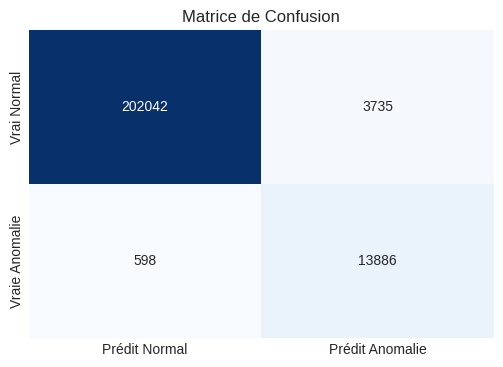

✅ Taux de détection (Recall) atteint : 95.9%


In [6]:
# Affichage du rapport de classification détaillé
print("--- Rapport de Classification ---")
print(classification_report(y_true, y_pred, target_names=['Normal (0)', 'Anomalie (1)']))

# Matrice de confusion pour visualiser concrètement les détections
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Prédit Normal', 'Prédit Anomalie'],
            yticklabels=['Vrai Normal', 'Vraie Anomalie'])
plt.title("Matrice de Confusion")
plt.show()

# Extraction spécifique du Recall pour la conclusion
report = classification_report(y_true, y_pred, output_dict=True)
recall_anomalies = report['1']['recall'] * 100
print(f"✅ Taux de détection (Recall) atteint : {recall_anomalies:.1f}%")


## 8. Visualisation : Focus sur une Panne

Visualisons comment le modèle a identifié les anomalies sur l'un des capteurs thermiques justes avant et pendant une panne.

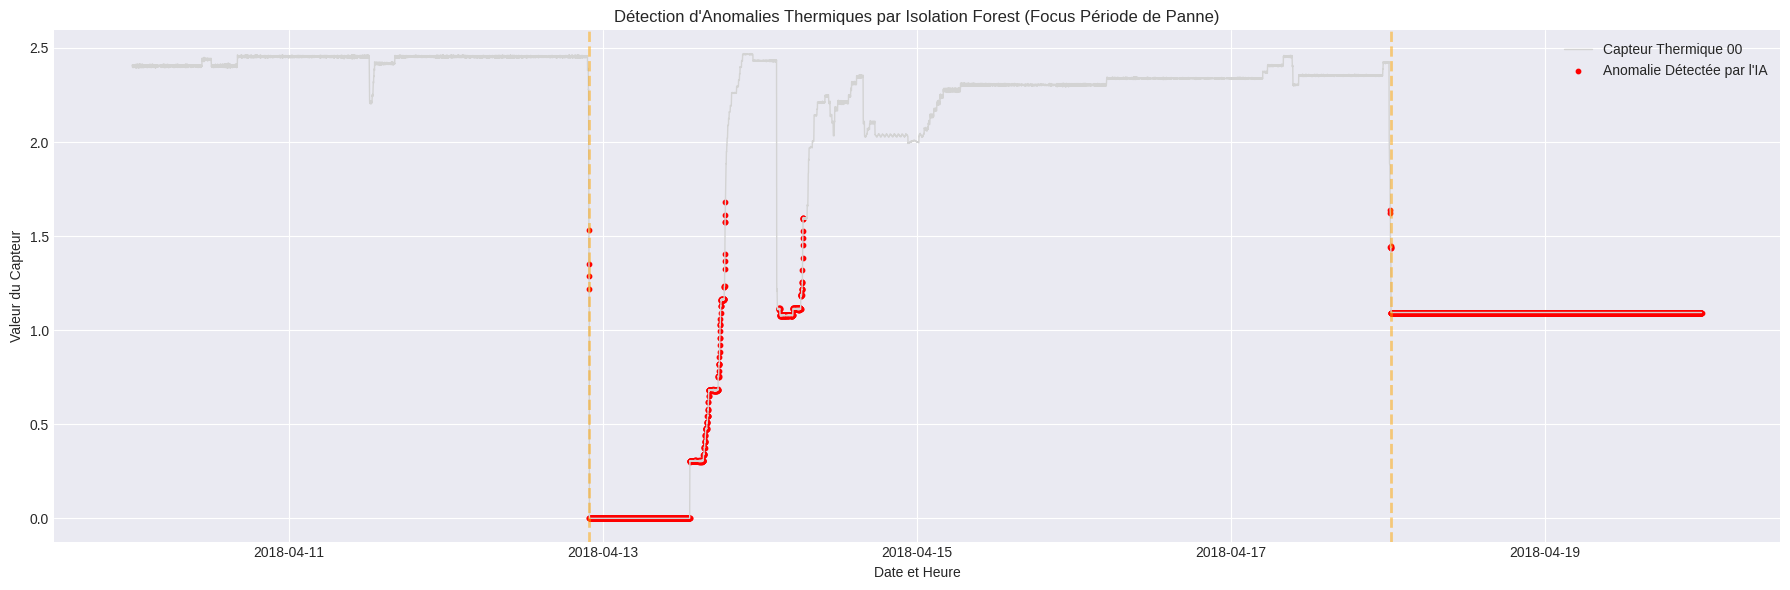

In [7]:
# Pour la lisibilité, on se concentre sur une fenêtre de temps spécifique contenant une panne
# La première panne dans ce dataset a lieu vers le mois d'avril
window_start = '2018-04-10 00:00:00'
window_end = '2018-04-20 00:00:00'

# Création d'un sous-dataframe temporaire pour le plot
plot_df = pd.DataFrame(index=X_features.index)
plot_df['sensor_00'] = X_features['sensor_00']
plot_df['Anomalie_Prevue'] = y_pred
plot_df['Statut_Reel'] = y_status

# Filtrage sur la fenêtre de temps
plot_df = plot_df.loc[window_start:window_end]

plt.figure(figsize=(18, 6))

# Tracé du capteur thermique
plt.plot(plot_df.index, plot_df['sensor_00'], label='Capteur Thermique 00', color='lightgrey', linewidth=1)

# Mise en évidence des prédictions d'anomalies (Points Rouges)
anomalies_predites = plot_df[plot_df['Anomalie_Prevue'] == 1]
plt.scatter(anomalies_predites.index, anomalies_predites['sensor_00'], color='red', s=10, label='Anomalie Détectée par l\'IA')

# Zones de pannes réelles (Surlignage jaune)
pannes_reelles = plot_df[plot_df['Statut_Reel'] == 'BROKEN']
for timestamp in pannes_reelles.index:
    plt.axvline(x=timestamp, color='orange', alpha=0.5, linestyle='--', linewidth=2)

plt.title("Détection d'Anomalies Thermiques par Isolation Forest (Focus Période de Panne)")
plt.xlabel("Date et Heure")
plt.ylabel("Valeur du Capteur")
plt.legend()
plt.tight_layout()
plt.show()